W poprzednich częściach poznawaliśmy co to "pipeline" w SciKit-Learn, tworzyliśmy własne estymatory (przy okazji ucząc się trochę o programowaniu obiektowym, klasach i dziedziczeniu - nawet jeśli to było nieświadome). Dzisiaj ostatnia część z cyklu - kręcenie śróbkami zwanymi hyperparametrami.

W poprzedniej części przeszuliwaliśmy siatkę hyperparametrów (wszyskie możliwe kombinacje) przy użyciu wbudowanych w SciKit-Learn mechanizmów (na przykład GridSearchCV). Dzisiaj poszukamy innej metody, innego pakietu. A będzie nim `hyperopt`.


Zaczniemy od tego dlaczego `hyperopt` a nie `GridSearch`? Ano dlatego, że pakiet hyperopt posiada kilka funkcji, które pozwalają na zdefiniowanie przestrzeni parametrów (czyli elementów na siatce) w sposób w którym nie musimy podawać każdej z wartości (jako np. listę) a możemy użyć funkcji generujących rozkład wartości dla każdego z parametrów. Później określamy np. ile czasu ma trwać szukanie najlepszej kombinacji (albo ile ktorków) i pakiet za nas dobiera najlepsze kombinacje. Oczywiście dobór odbywa się na podstawie szukania namniejszej wartości błędu (*najmniejszej straty*), a nad tym co jest stratą mamy kontrolę. Może ten opis jest zagmatwany, dlatego dłuższy ale prosty przykład.


Oczywiście zaczynamy od importu pakietów i małej konfiguracji:

In [1]:
from hyperopt import hp, fmin, tpe, STATUS_OK, space_eval
from hyperopt import Trials

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")

Będziemy szukać współrzędnej X wierzchołka paraboli. Bo to taka funkcja, która ma jedno konkretne minimum (lub maksimum) i dość łatwo na tym przykładzie zrozumieć ideę działania samego hyperopt ale też *funkcji straty*.

In [2]:
# definiujemy sobie funkcję obliczającą wartość Y w konkretnym punkcie X
def parabola(x, pa, pb, pc):
    return pa * x**2 + pb * x + pc

# parablolę opisują 3 wskaźniki, niech będą takie:
a, b, c = (-2, 8, -4)

Na początek zobaczmy jak nasza parabola wygląda:

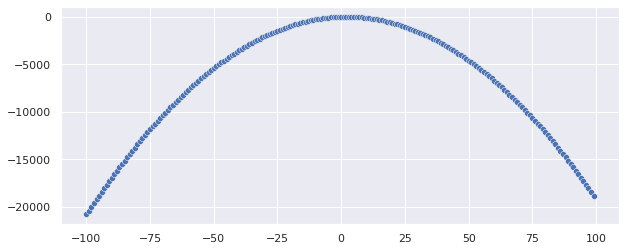

In [27]:
x = np.arange(-100,100)
y = parabola(x, a, b, c)

fig, ax = plt.subplots(figsize=(10, 4))
sns_plot = sns.scatterplot(x=x, y=y)

plt.show()
sns_plot.get_figure().savefig('hyperopt_01.png')

Mamy więc wykukłą ku górze krzywą, będziemy szukać punktu najwyżej położonego. Ten punkt ma wartość:

In [4]:
y_max = np.max(y)
y_max

4

a przyjmuje ją dla argumentu:

In [5]:
x[np.argmax(y)]

2

Oczywiście można to policzyć matematycznie, ale... nie pamiętam wzoru na wierzchołek paraboli, a wyprowadzać tego poprzez szukanie miejsca zerowego pierwszej pochodnej mi się nie chce.

Będziemy szukać takiej wartości argumentu *funkcji straty* aby owa *strata* była jak najmniejsza. Czyli odległość (w sensie wartości funkcji, Y) od naszego wierzchołka paraboli musi byc najmniejsza. Przygotujmy więc odpowiednią funkcję straty:

In [6]:
def funkcja_straty(args):
    # hyperopt przekazuje słownik parametrów - wyciągamy z niego nasz X
    x = args['x']
    
    # obliczamy Y na naszzej paraboli (a, b i c są stałe)
    y = parabola(x, a, b, c)
    
    # do hyperopt zwracamy słownik:
    # - status (udało się)
    # - opcjonalnie zwracamy jakieś inne argumenty
    # - koniecznie wartość straty
    return {'loss': abs(y_max-y), 'status': STATUS_OK, 'type': args['type']}

Jak wspomniałem wyżej - stratą jest odległość od wierzchołka i chcemy aby była (idealnie) równa zero. Stąd absolutna wartość powyżej w elemencie *loss*.

Teraz zdefiniujemy sobie przestrzeń parametrów w jakich będziemy szukać naszego idealnego X. Tutaj pojedziemy od razu po bandie i powiemy, że mamy 3 warianty budowania wartości X:

In [7]:
parabola_space = hp.choice('wiercholek_x',
    [
    {
        'type': 'x_normal',
        'x': hp.normal('x_normal', 0, 300) # rozkład normalny o średniej 0 i odychleniu 300
    },
    {
        'type': 'x_randint',
        'x': hp.randint('x_randint', -1000, 1000) # losowa liczba całkowita z przedziału -1000 ; 1000
    },
    {
        'type': 'x_uniform',
        'x': hp.uniform('x_uniform', -1000, 1000) # rozkład jednorodny z przedziału -1000 ; 1000
    }
    ])

Czas na najważniejszą część. Wywołujemy szukanie minimum *funkcji straty*. Tutaj mówimy, że nei więcej niż 1000 kroków, korzystają z przestrzeni parametrów jak wyżej (wybór jednego z trzech typów rozkładów i w ramach niego jakiejś liczby), a wybór odpowiednich parametrów zostawiamy algorytmowi (*tpe.suggest*):

In [8]:
best = fmin(funkcja_straty, parabola_space, algo=tpe.suggest, max_evals=1000)

100%|██████████| 1000/1000 [00:17<00:00, 56.31trial/s, best loss: 0.016740598669704454]


Chwilę to trwa i dostajemy najlepszy wynik:

In [9]:
best

{'wiercholek_x': 0, 'x_normal': 2.091489340006651}

Jak to czytać? Najlepiej sprawdził się zerowy element tablicy wyboru rozkładów (a więc rozkład *x_normal*) i wartość x w okolicach dwójki. Oczywiście rozkłady są losowe, więc za każdym razem może wyjść nieco inna liczba. Przy zwiększeniu loczy kroków do np. 10 tysięcy dostaniemy lepszą precyzję (testując w okolicach 3 tysięcy kroków miałem dokładność na poziomie 2e-5, po 10 tysiącach strata była na poziomie 7e-7).

No dobrze, ale to jest najlepszy wynik (co może byc wystarczające) będący najlepszą kombinacją hyperparametrów (tutaj jednego - wartości X). A może chcemy znać całą historię szukania, ze wszystkimi kombinacjami? Tutaj wchodzi zapisywanie kolejnych prób i obiekty typu "Trials". Zmiana jest minimalna - tworzymy obiekt, a później podajemy go do *fmin()*:

In [10]:
trials = Trials()

# usuwamy rozkład normalny - bez niego łatwiej będzie coś zaobserwować
parabola_space_v2 = hp.choice('wiercholek_x',
    [
    {
        'type': 'x_randint',
        'x': hp.randint('x_randint', -1000, 1000) # losowa liczba całkowita z przedziału -1000 ; 1000
    },
    {
        'type': 'x_uniform',
        'x': hp.uniform('x_uniform', -1000, 1000) # rozkład jednorodny z przedziału -1000 ; 1000
    }
    ])

best = fmin(funkcja_straty, parabola_space_v2, algo=tpe.suggest, max_evals=500, trials=trials)

100%|██████████| 500/500 [00:05<00:00, 91.20trial/s, best loss: 1.4484822582646988] 


Teraz każdy przebieg mamy zapisany w pamięci i możemy to wykorzystać. Na przykład najlepszy wynik dało:

In [11]:
trials.best_trial

{'state': 2,
 'tid': 34,
 'spec': None,
 'result': {'loss': 1.4484822582646988, 'status': 'ok', 'type': 'x_uniform'},
 'misc': {'tid': 34,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'wiercholek_x': [34], 'x_randint': [], 'x_uniform': [34]},
  'vals': {'wiercholek_x': [1],
   'x_randint': [],
   'x_uniform': [1.148976422693032]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2020, 12, 23, 9, 35, 27, 472000),
 'refresh_time': datetime.datetime(2020, 12, 23, 9, 35, 27, 472000)}

Co tutaj widać:
* strata w ramach *result / loss*
* użyte parametry w *vals* (nazwa użyta do oznaczenia rozkładu i wartość jaką przyjął X)


Zwróć uwagę, że tutaj było mniej przebiegów, zatem i błąd większy (nie zdążyła znaleźć się ta najlepsza wartość).

Wyniki mamy w formie listy zagnieżdżonych obiektów. Możemy z tego powyjmować interesujące elementy do tabeli i przygotować jakieś zestawienia.

In [12]:
trials_df = []

for trial in trials.trials:
    trials_df.append({
        'loss': trial['result']['loss'],
        'type': trial['result']['type'],
        'x': trial['misc']['vals'][trial['result']['type']][0]
        })

trials_df = pd.DataFrame(trials_df)
trials_df['index'] = trials_df.index

trials_df.head()

,loss,type,x,index
0,1.489538e+06,x_randint,-861.000000,0
1,5.140980e+05,x_randint,509.000000,1
2,3.718242e+04,x_uniform,-134.349583,2
3,2.723220e+05,x_randint,371.000000,3
4,1.446692e+05,x_uniform,-266.950891,4


Zobaczmy czy każdy z typów rozkładów był użyty tyle samo razy (czyli czy algorytm rozłożył sobie wszystkie możliwe parametry w siatkę i przeszedł ją jakoś równo, czy używając już zdobytych informacji o *stracie* optymalizował drogę?

In [13]:
trials_df.value_counts('type', ascending=False)

type
x_uniform    424
x_randint     76
dtype: int64

Jak widać nie każdy z rozkładów użyty był tak samo często. Zobaczmy na wykresie jakie X były losowane i jaką dawały stratę:

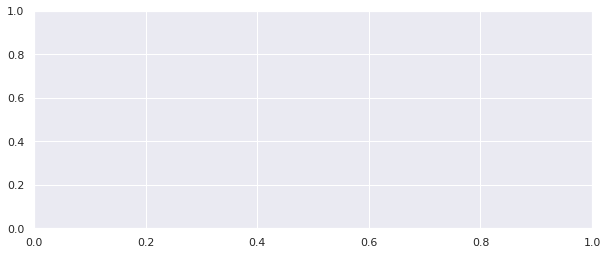

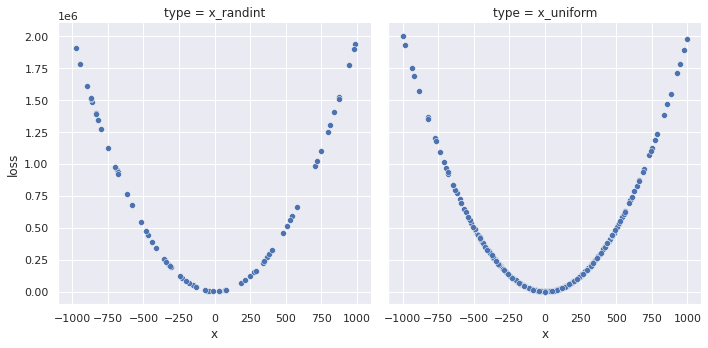

In [33]:
fig, ax = plt.subplots(figsize=(10, 4))

m = sns.FacetGrid(data=trials_df, col='type', height=5)
sns_plot = m.map(sns.scatterplot, 'x', 'loss')

sns_plot.savefig('hyperopt_02.png')

Wygląda z grubsza, że każda z liczby X była losowana mniej więcej tyle samo razy. Ale ten wykres jest mylący - trzeba to zweryfikować inaczej:

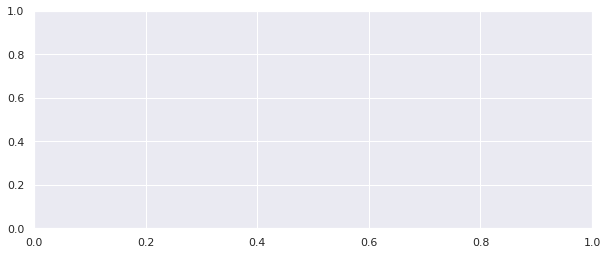

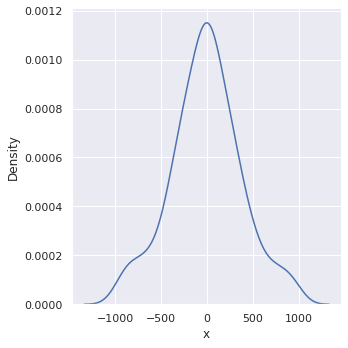

In [37]:
fig, ax = plt.subplots(figsize=(10, 4))

sns_plot = sns.displot(trials_df.x, kind = "kde")

sns_plot.savefig('hyperopt_03.png')

Mamy szeroki zakres (łącznie przestrzeń szerokości 2000 jednostek), losowany na dwa sposoby z rozkładem jednostajnym (właściwie dwoma) - więc każda z liczb powinna być tak samo prawdopodobna do wylosowania. Ale wynik pokazuje zbliżanie się do roskładu normalnego (przechodząc proces 10 tysięcy razy widać to jeszcze lepiej - średnia zbliża się do naszej dwójki, a odchylenie standardowe maleje tak, że mamy właściwe *szpilkę* a ne *dzwon*). W sumie może Wam się udać to wcześniej - jeśli z *randint* wylosuje się dwójka to od razu jesteśmy w domu, bo *strata* ma wartość zerową.

Sprawdźmy czy im bliżej końca przebiegu osiągamy coraz lepsze wyniki (coraz mniejsza *strata*). Tutaj mamy sporą losowość, więc może być różnie.

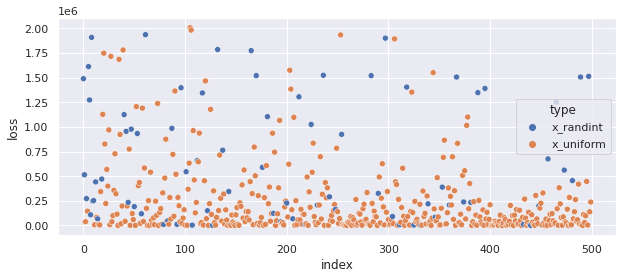

In [39]:
fig, ax = plt.subplots(figsize=(10, 4))

sns_plot = sns.scatterplot(data=trials_df, x='index', y='loss', hue='type')

sns_plot.get_figure().savefig('hyperopt_04.png')

Tyle wprowadzenia do hyperopt. To jest początek, ale pokrywający spory kawałek możliwości hyperopt. Więcej oczywiście w [dokumentacji](https://hyperopt.github.io/hyperopt/).

### Jak tego użyć?

Najbardziej sensownym i pewnie też najpipularniejszym użyciem jest szukanie najlepszego modelu i *kręcenie* śrubkami jego hyperparametrów. Zróbmy tak:
* przygotujemy jakieś sztuczne dane na potrzeby klasyfikacji
* przygotujmy szkielet - pipeline
* przygotujmy listę klas modeli (różne ich typy) razem z zakresem hyperparametrów jakimi można *kręcić* dla każdego z nich
* wytrenujmy i oceńmy każdą kombinację
* w wyniku dostaniemy najlepszą wersję (a w gratisie kilka cennych danych poszerzających wiedzę o tym jak hyperparametry wpływają na dany typ modelu)

In [40]:
from sklearn.pipeline import Pipeline

# ocena modelu
from sklearn.model_selection import cross_val_score

# nasze modele klasyfikacyjne
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# narzędzie do preparowania danych
from sklearn.datasets import make_classification

Przygotujemy dane. Wiele razy w takim przypadku szukałem jakiegoś zbioru, a przecież SciKit-Learn ma to tego znakomite funkcje w module *datasets*:

In [41]:
data = make_classification(n_samples=1000, n_classes=4, n_features=20, n_informative=16)

Trochę sobie te tane uporządujemy - po prostu wpakujemy w data frame:

In [42]:
X = pd.DataFrame(data[0])
X.columns = [f"col_{i}" for i in X.columns]
y = data[1]

Czas na przygotowanie klasyfikatorów i zakresu zmian ich hyperparametrów.

Właśnie przeczytałem świetną książkę (dla średniozaawansowanych pythonowców idealna) ["Python. Dobre praktyki profesjonalistów" autorstwa Dane Hillard](https://helion.pl/view/14029A/pytdop.htm) więc przekazuję odrobinę zdobytej wiedzy - można konfigurację każdego z klasyfikatorów ubrać w element typu *dict*, a potem w jednej pętli przejść przez wszystkie. Poniżej 5 konfiguracji (lista 5 elementów typu słownik) dla 5 różnych klasyfikatorów:

In [43]:
classifiers = [
    {
        'name': 'RandomForestClassifier()',
        'class': RandomForestClassifier(),
        'max_evals': 50,
        'params': {
            'n_estimators': hp.uniformint('n_estimators', 10, 250),
            'max_depth': hp.uniformint('max_depth', 2, 20)
           }
    },
    {
        'name': 'KNeighborsClassifier()',
        'max_evals': 20,
        'class': KNeighborsClassifier(),
        'params': {
            'n_neighbors': hp.uniformint('n_neighbors', 1, 10),
            'p': hp.choice('p', [1, 2])
        }
    },
    {
        'name': 'SVC()',
        'class': SVC(),
        'max_evals': 4,
        'params': {
            'kernel': hp.choice('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
        }
    },
    {
        'name': 'AdaBoostClassifier()',
        'class': AdaBoostClassifier(),
        'max_evals': 20,
        'params': {
            'n_estimators': hp.uniformint('n_estimators', 10, 250),
            'learning_rate': hp.uniform('lr', 0.01, 0.05)
            }
    },
    {
        'name': 'XGBClassifier()',
        'class': XGBClassifier(),
        'max_evals': 100,
        'params' : {
            'learning_rate': hp.loguniform ('learning_rate', 0.01, 0.5),
            'max_depth': hp.choice('max_depth', np.arange(2, 11).tolist()),
            'min_child_weight': hp.choice('min_child_weight', np.arange(0, 101).tolist()),
            'gamma': hp.loguniform('gamma', 0.0, 2.0),
            'subsample': hp.uniform('subsample', 0.5, 1.0),
            'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
            'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1.0),
            'reg_alpha': hp.loguniform('reg_alpha', 0.0, 2.0),
            'reg_lambda': hp.loguniform('reg_lambda', 0.0, 2.0)
        }
    }
]


Jednak aby hyperopt mógł dać jakiś wynik potrzebujemy *funkcji straty*. Oto i ona (wraz z odpowiednim komentarzem):

In [44]:
def objective(space):
    # miejsce na parametry dla Pipeline
    pipe_params = {}

    # przechodzimy przez listę parametrów dla estymatora i budujemy ich słownik
    for s in space:
        pipe_params[f"classifier__{s}"] = space[s]
    
    # dostrajamy Pipeline - podajemy mu zebrane parametry
    pipeline.set_params(**pipe_params)
    
    # oceniamy model - używamy cross-validacji i wyciągamy średnią z "accuracy" dla 10 przebiegów
    score = cross_val_score(pipeline, X, y, cv=10, scoring="accuracy").mean()

    # im większe "accuracy" tym lepiej - zatem strata to 1-accuracy (max accuracy to 1)
    # przy okazji do traials zwracamy też "czyste" accuracy
    return {'loss': 1- score, 'status': STATUS_OK, 'accuracy': score}

Teraz kiedy wszsystko przygotowane możemy puścić pętlę przez wszystkie zdefiniowane wcześniej klsyfikatory (razem z ich przestrzenią hyperparametrów). Dla każdego z klasyfikatorów poniższy kod:
* przygotuje pusty pipeline
* przygotuje przestrzeń hyperparametrów *space*
* znajdzie najlepszą konfigurację i ją wyświetli
* a wszystkie przejścia dla wszystkich modeli dopisze do listy *trials_df*

Całość trochę trwa, więc możesz uruchomić kod i iść na przykład na kawę:

In [45]:
%%time

trials_df = []

for cl in classifiers:
    cl_name = cl['class'].__class__.__name__
    print(f"\n\n{cl_name}")

    pipeline = Pipeline(steps=[('classifier', cl['class'])])

    space = {}
    for k in cl['params']:
        space[k] = cl['params'][k]

    max_evals = cl['max_evals']

    trials = Trials()
    best = fmin(fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=max_evals,
                    trials=trials)

    best_params = space_eval(space, best)
    print('\nThe best params:')
    print ("{:<30} {}".format('Parameter','Selected'))
    for k, v in best_params.items():
        print ("{:<30} {}".format(k, v))

    for trial in trials.trials:
        trials_df.append({
            'classifier': cl_name,
            'loss': trial['result']['loss'],
            'accuracy': trial['result']['accuracy'],
            'params': trial['misc']['vals']
            })



RandomForestClassifier
100%|██████████| 50/50 [05:44<00:00,  6.88s/trial, best loss: 0.20799999999999996]

The best params:
Parameter                                                    Selected
max_depth                                                    17
n_estimators                                                 186


KNeighborsClassifier
100%|██████████| 20/20 [00:04<00:00,  4.95trial/s, best loss: 0.19999999999999996]

The best params:
Parameter                                                    Selected
n_neighbors                                                  5
p                                                            2


SVC
100%|██████████| 4/4 [00:06<00:00,  1.66s/trial, best loss: 0.18599999999999994]

The best params:
Parameter                                                    Selected
kernel                                                       rbf


AdaBoostClassifier
100%|██████████| 20/20 [02:13<00:00,  6.69s/trial, best loss: 0.40800000000000003]

The best p

Zebrane wyniki (*trials_df*) mamy w postaci listy słowników, więc przekształćmy ją w zwykły pandasowy data frame:

In [46]:
trials_df = pd.DataFrame(trials_df)

Teraz możemy porównać wyniki i same modele ze sobą. W klasyfikacji interesuje nam *accuracy* więc to sobie zobaczmy:

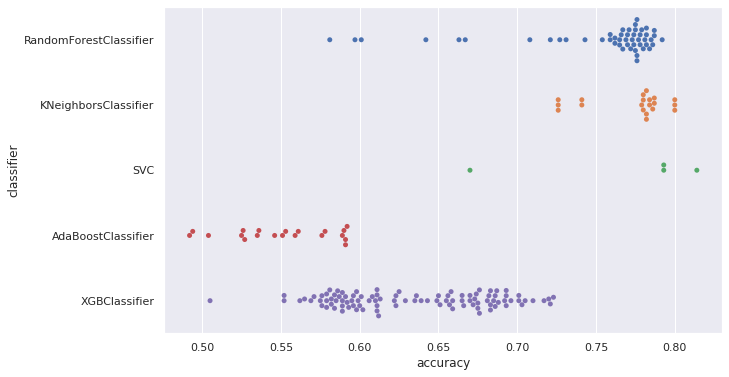

In [48]:
fig, ax = plt.subplots(figsize=(10, 6))

sns_plot = sns.swarmplot(data=trials_df, y='classifier', x='accuracy')

sns_plot.get_figure().savefig('hyperopt_05.png')

Widzimy tutaj, że każdy z klasyfikatorów był testowany różną ilość razy (różna liczba kropek) - ale to oczywiście zależy od wartości "max_evals" jaką przypisaliśmy w konfiguracji. 

Możemy wybrać jeden z klasyfikatorów (na przykład *XGBoost* - miał najwięcej parametrów i najbardziej był *męczony*) i sprawdzić jak ma się *accuracy* w zależności od wartości poszczególnych hyperparametrów:

In [49]:
# wybieramy tylko wyniki dla klasyfikatora XGBoost
xgb_trails = trials_df[trials_df['classifier'] == 'XGBClassifier'][['accuracy', 'params']]

# rozszerzamy kolumnę ze słownikiem na kolumny z poszczególnych elementów słownika i pakujemy w jedną ramkę razem z 'accuracy'
xgb_trails = pd.concat([xgb_trails[['accuracy']], xgb_trails.params.apply(pd.Series)], axis=1)

# wartości dla elementów słownika zostały jako listy (jednoelementowe) - wydobywamy je poza listę
for col in xgb_trails.select_dtypes(include=[list]).columns:
    xgb_trails[col] = xgb_trails[col].apply(lambda x: x[0])
    
# robimy tabelkę "tidy" na potrzebę wykresów
xgb_trails_tidy = xgb_trails.melt(id_vars='accuracy', var_name='param', value_name='value')

Oczywiście najlepiej to widać na wykresie, zatem:

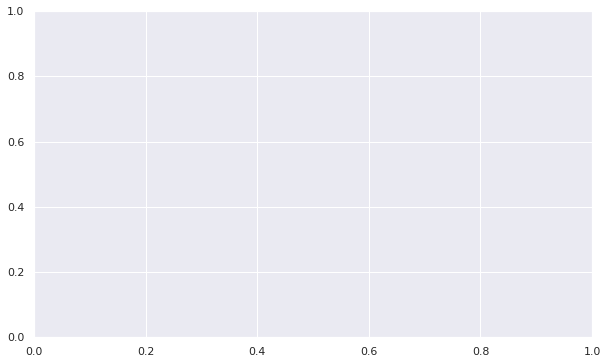

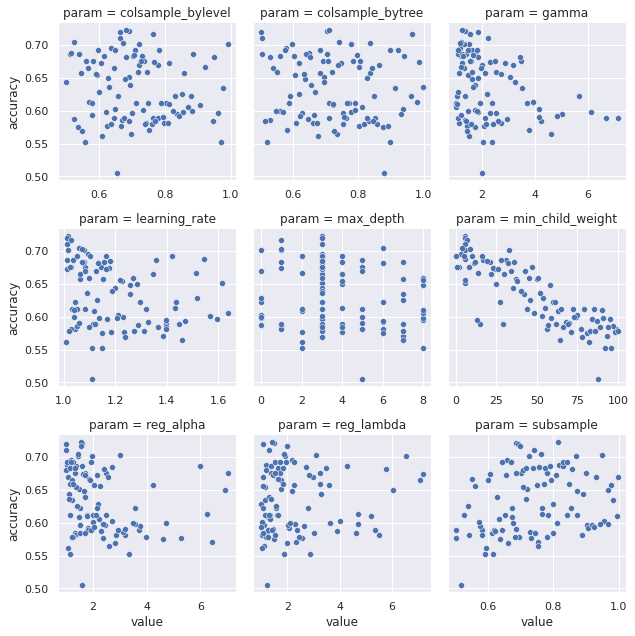

In [52]:
fig, ax = plt.subplots(figsize=(10, 6))


m = sns.FacetGrid(xgb_trails_tidy, col='param', sharex=False, col_wrap=3)
sns_plot = m.map(sns.scatterplot, 'value', 'accuracy')

sns_plot.savefig('hyperopt_06.png')

Porównajcie powyższe wykresy z tym, co hyperopt zwrócił jako najlepsze wartości wyżej:

In [55]:
best_params = space_eval(space, best)
print('\nThe best params:')
print ("{:<20} {}".format('Parameter','Selected'))
for k, v in best_params.items():
    print ("{:<20} {}".format(k, v))


The best params:
Parameter            Selected
colsample_bylevel    0.683400163467327
colsample_bytree     0.7104695618656047
gamma                1.2376589690699886
learning_rate        1.0190683081514302
max_depth            5
min_child_weight     6
reg_alpha            1.541960399289685
reg_lambda           1.4133166551487888
subsample            0.8162682051326297


Prawda, że spójne?


Oczywiście do pipeline można dodać transformację danych i też to przepuścić przez hyperopt - wtedy robi się kompleksowa maszyna do szukania najlepszego modelu. Warto każdy z tak wytrenowanych modeli zapisać w plikach (w ogóle warto wersjonować modele, razem z informacją o ich parametrach - poczytaj na przykład o [MLFlow](https://mlflow.org/) jeśli ten temat Cię interesuje) aby ewentualnie spradzić kilka wytrenowanych wersji na produkcyjnych danych. Można cały proces przygotować tak, że modele *douczają się* co jakiś czas, a można też tak że z użyciem hyperopt szukamy za każdym razem tego najlepszego.